# 数理手法Ⅶ 時系列解析 第3回 レポート
#### 計数工学科 数理情報工学コース 3年
#### 学生証番号: XX-XXXXXX 氏名: 佐藤 瞭
#### 連絡先: XXX

---

In [1]:
library('TSSS')
library('TTR')
library('tseries')
library('forecast')
library('changepoint')

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.


---

# 1. 目的

## 目的A: ある製品の未来の生産量や、その製品の業界が獲得する利益を予測すること。

予測ができれば、関連企業の株の取引により利益を得ることができないかと考えた。また、製造業で就職や起業を考える際に、未来の市場の規模や利益の上げやすさを予測することで、将来有望な製品の種類を推測できるようになると考えた。

## 目的B: 生産量や利益の変化点を検出すること。

生産量や利益に影響を与えると思われる出来事との関係がないか調べてみようと思ったため。（たとえば、鳥インフルエンザの流行は鶏肉の生産量を減らすのではないか、という仮説をたてることができる。）ある時点が変化点となった原因の事例を集めることで、将来似たようなことがあったときに生産量や利益のトレンドの大まかな変化を予測できるのではないかと考えた。

目的に合うデータを探したところ、生産量や利益を直接示すようなまとまったデータは得られなかったので、これらに影響を強く受けるであろう指標として、鉱工業生産指数（付加価値ベース）を用いる。データは
https://www.meti.go.jp/statistics/tyo/iip/b2010_result-2.html
から取得し、1993年01月から2008年08月の、月次のデータを得た。今回は乳製品のデータを解析する。

---

# 2. 解析

In [2]:
data <- read.csv('iip.csv')
milk <- data[['milk']]
milk_ts = ts(as.numeric(milk), frequency = 12)

## 目的Aに対する、鉱工業生産指数の予測

SARIMAモデルを用いて予測した。

#### (a) 手法の概要  
SARIMAモデルは、ARIMAモデルに季節調整を加えたモデルである。パラメータには、前季に対する回帰の次数や、前季との差分の回数、前季の階差のラグ数、1季の長さが含まれる。  
ARIMAモデルは、ARモデルやMAモデルに加えて、データの定常化を行うモデルである。パラメータは、自己回帰の次数、差分の回数、定常化のための階差のラグ数の3つとなる。 
データのトレンドが波打っていたことから、ARモデルの要素に加えて季節調整も行えるSARIMAモデルが、データに適しているのではないかと考えて採用し、解析を行った。

今回は、`forecast`パッケージの`auto.arima`関数を用いてモデルのフィッティングやパラメータ最適化を行った。パラメータ探索は、AICが小さくなるような探索になるように設定した。

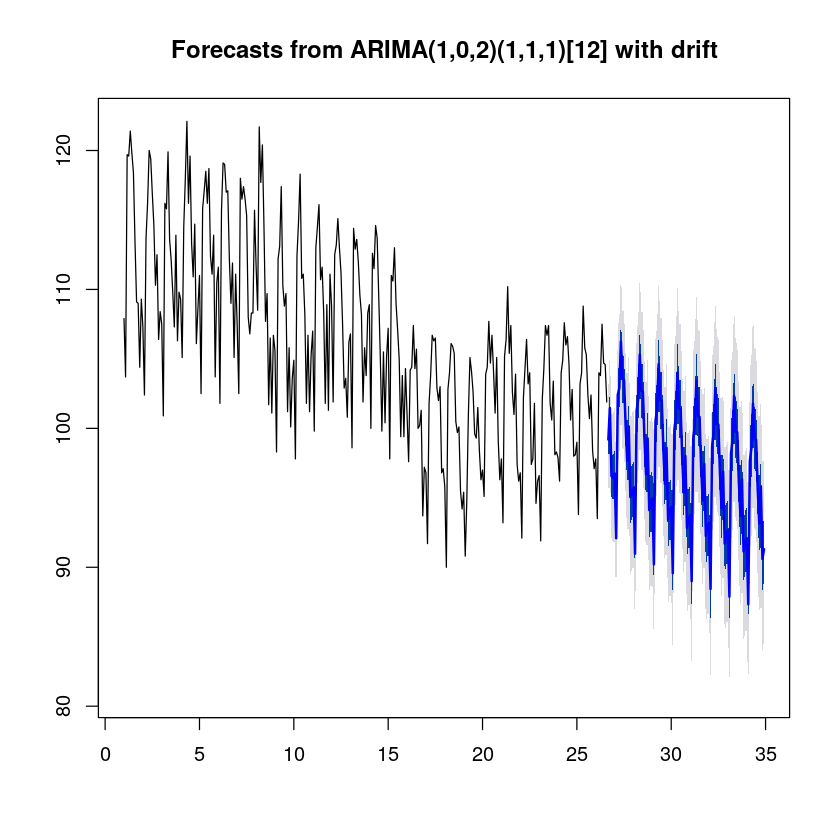

In [3]:
model_sarima <- auto.arima(
    milk_ts, ic = "aic",
    seasonal = T,
    stepwise = F,
    approximation = F,
    parallel = T)
plot(forecast(model_sarima, level = c(50,95), h = 100))

In [4]:
model_sarima

Series: milk_ts 
ARIMA(1,0,2)(1,1,1)[12] with drift 

Coefficients:
         ar1      ma1     ma2    sar1     sma1    drift
      0.7906  -0.3566  0.1347  0.3695  -0.8676  -0.0458
s.e.  0.0592   0.0768  0.0745  0.0835   0.0587   0.0095

sigma^2 estimated as 3.592:  log likelihood=-611.14
AIC=1236.27   AICc=1236.66   BIC=1262.1

#### (b) 推定結果
AICは`1236.27`となった。パラメータは、ARIMAモデルの部分のパラメータ`(自己回帰の次数、差分をとる回数、階差のラグ数)`は`(1, 0, 2)`となり、季節要素のパラメータ`(前季に対する回帰の次数、前季との差分をとる回数、前季の階差のラグ数)`は`(1, 1, 1)`となった。なお、1季の長さは`12`とした上でモデルにフィッティングさせている。

#### (c) 得られた知見
長期の予測になっても信頼区間の幅が広がりにくい。周期的な振動も予測で再現できている上に、信頼区間も振動している。未来の値の予測はSARIMAモデルで行っても、ある程度の精度で行えるように思える。

#### (d) 問題点の検討

予測値の振動の平均が下降している点が気になった。データを見る限りでは、区分的に平均定常となっているように見える。予測値で、区分的に平均定常になるような傾向を再現できると、より現実に近い予測ができるのではないかと考えた。

---

## 目的Bに対する、変化点検出

#### (a) モデルの説明
Rの`changepoint`パッケージ( https://cran.r-project.org/web/packages/changepoint/changepoint.pdf )を用いた。変化点でデータを区切って尤度を求め、区切ったあとの尤度の、区切る前の尤度に対する比が最も大きくなるような変化点を求めるという方針である。目的関数を負の対数尤度とすることで最小化問題となる。変化点を一箇所求めるだけであればこの設定でよいが、変化点を複数求める際には工夫が必要となる。なぜならば、変化点を増やすほど尤度は必ず改善するので、最適な変化点の個数がわからなくなってしまうためである。そこで、変化点を増やすたびに大きくなるようなペナルティ項を目的関数に追加することで、変化点の個数も含めて推定することができるようになる。  
今回は、平均および分散の変化をみることで、データの背景にある構造の変化を探ることにした。

#### (b) 推定結果

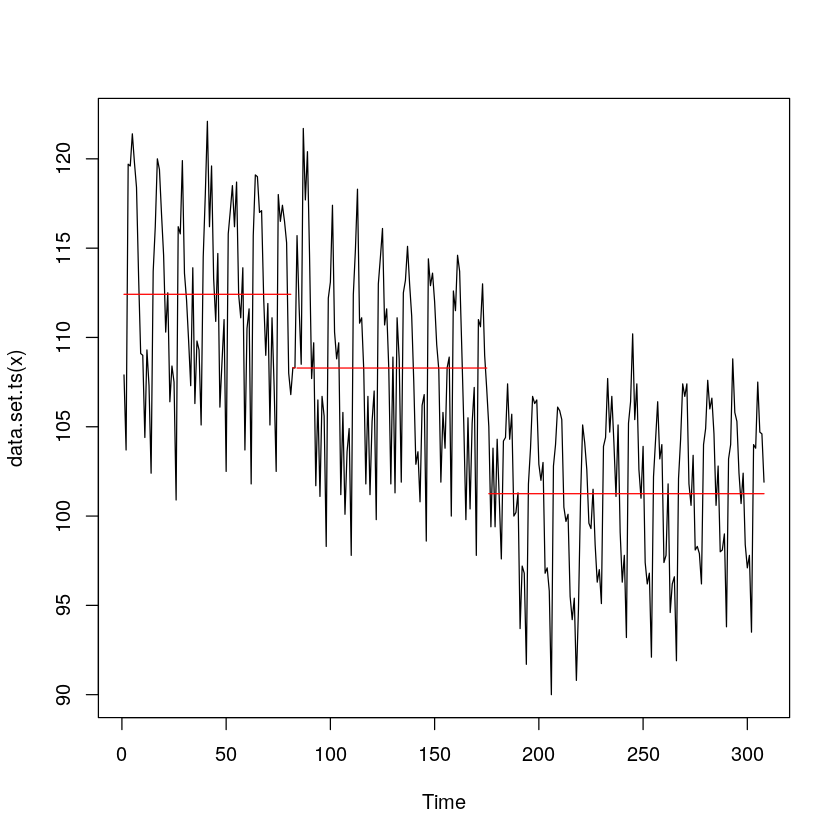

In [5]:
x = cpt.meanvar(milk, method = "PELT")
plot(x)

In [6]:
x

Class 'cpt' : Changepoint Object
       ~~   : S4 class containing 12 slots with names
              cpttype date version data.set method test.stat pen.type pen.value minseglen cpts ncpts.max param.est 

Created on  : Tue May 28 13:05:46 2019 

summary(.)  :
----------
Created Using changepoint version 2.2.2 
Changepoint type      : Change in mean and variance 
Method of analysis    : PELT 
Test Statistic  : Normal 
Type of penalty       : MBIC with value, 22.9204 
Minimum Segment Length : 2 
Maximum no. of cpts   : Inf 
Changepoint Locations : 81 83 175 

上の結果からわかるように、81個目、83個目、175個目のデータが変化点であるという結果を得た。

#### (c) 得られた知見など

データは区分的に平均定常であり、`changepoint`で得られた変化点は、データを平均定常な区間に分割できているようにみえる。

第2回のレポートとは異なる場所が変化点である、という結果を得た。具体的な年月は、`1999-09`、`1999-11`、`2007-07`の3点である。

#### (d) モデルの問題点の検討

`1999-09`と`1999-11`の2つの変化点は、モデル上では別々の変化点としてみなされているようだが、この2点は2ヶ月しか空いておらず、その2ヶ月の間にデータが異常な値をとっているということもないので、この2つの変化点はまとめて1つとみなしていいように思える。そこで、変化点によって分割される区間の長さの下限を設けて、変化点がどうなるかみてみる（変化点の個数は相変わらず指定していないことに注意された）。12ヶ月の周期的なデータであることから、変化点によって分割される区間の長さの下限を12ヶ月としてみた。

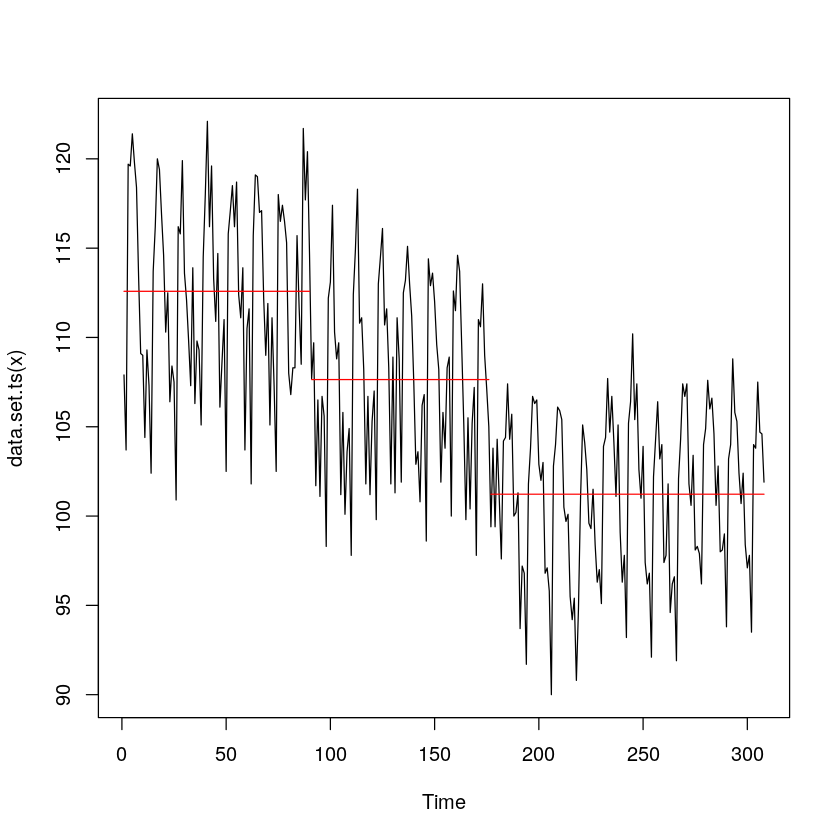

In [7]:
x_ = cpt.meanvar(milk, method = "PELT", minseglen = 12)
plot(x_)

In [8]:
x_

Class 'cpt' : Changepoint Object
       ~~   : S4 class containing 12 slots with names
              cpttype date version data.set method test.stat pen.type pen.value minseglen cpts ncpts.max param.est 

Created on  : Tue May 28 13:05:46 2019 

summary(.)  :
----------
Created Using changepoint version 2.2.2 
Changepoint type      : Change in mean and variance 
Method of analysis    : PELT 
Test Statistic  : Normal 
Type of penalty       : MBIC with value, 22.9204 
Minimum Segment Length : 12 
Maximum no. of cpts   : Inf 
Changepoint Locations : 90 176 

`2000-06`、`2007-08`の2点が変化点である、という結果になった。

まず、`2000-06`が変化点、という結果は前回のレポートの結果に近い（第2回レポートで得られた変化点の1つは`2000-07`であり非常に近い時期である）。この時期が変化点になった原因の考察は前回のレポートで行っている。以下に再掲する:
```
2000年6月には雪印乳業食中毒事件[1]が発生していた。この事件により乳製品の売上が減少し、利益減少による付加価値の減少につながった可能性が考えられる。
```

つぎに、`2007-08`が変化点、という結果に対する説明を考えてみる。この頃には、世界的に乳製品市場が逼迫した状況になってきており[2]、牛の飼料価格も高騰していたという。原材料の価格上昇が、製品の付加価値減少に繋がった可能性が考えられる。

----

# 3 総合的な考察

## (a)
目的は以下の2つであった:
- 目的A: ある製品の未来の生産量や、その製品の業界が獲得する利益を予測すること。
- 目的B: 生産量や利益の変化点を検出すること。

これらの課題はデータに基づく分析ができるようなものであったと考えている。実際、目的AはSARIMAモデルで、目的Bは`changepoint`である程度の分析を行うことができた。取得したデータの、鉱工業生産指数という指標は、製品種別ごとの生産量や利益をみるのに適したデータであると考えている。

## (b)
### 目的Aについて
期待通りの結果になった点:
- 12ヶ月周期のトレンドを再現することができた。
- 長期予測に対しても信頼区間が拡がりにくく、より確信の強い予測モデルを作成できた。  

期待通りにならなかった点:
- 平均は区分的に定常だが、予測値の平均は区分的定常にならなかった。フィッティングに用いたデータ全体での平均が減少する傾向のみ真似てしまっている状態である。

面白い知見:
- 季節調整をしないARIMAモデルでは、長期の予測で信頼区間が拡がってしまったり、予測値の周期的振動が減衰してしまったり、といった問題があった。ARIMAモデルに季節調整を加えることでこの問題点が解消されりところが個人的に面白かった。

### 目的Bについて

期待通りの結果になった点:
- 得られた変化点は、データを目視で確認しても違和感のないものとなった。

期待通りにならなかった点:
- 現状は特にない。先述の変化点が近すぎる、という問題も、変化点の間隔に下限を設けることで解消できている。この下限の値は調整の余地があるが、データごとに調整していけば問題なく解析できると考えている。

## (c)

- 目的Aに関して、変化点検出でデータを平均定常なものたちに分割し、各データに対してARIMAモデルによるフィッティングを行い、モデルたちを何らかの方法で集合させることで（機械学習で、決定木を集めてランダムフォレストにするようなイメージ）、予測値は平均定常なものになるかもしれない。（SARIMAモデルでも定常化を行っているので、予測結果はあまり変わらないかもしれないが…）

- 少々強引な手ではあるが、Recurrent Neural Networkにデータを学習させるとまた違った傾向の予測を得られるかもしれない。

---

# 参考文献
[1] http://www.meg-snow.com/corporate/history/popup/oosaka.html 2019/07/03 閲覧。  

[2] http://www.meg-snow.com/news/archives/snowbrand/2008/documents/2008061101.html 2019/07/31 閲覧。